# Bining Discretization

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [2]:
# load the dataset
df = sns.load_dataset('titanic')[['age', 'fare', 'survived']]
df.head()

,age,fare,survived
0,22.0,7.2500,0
1,38.0,71.2833,1
2,26.0,7.9250,1
3,35.0,53.1000,1
4,35.0,8.0500,0


In [3]:
# Check for missing values in the DataFrame
df.isnull().sum()

age         177
fare          0
survived      0
dtype: int64

In [4]:
# Drop rows with missing values
df.dropna(inplace=True)

In [39]:
df.shape

(714, 3)

In [5]:
# Define features and target variable
X = df[['age', 'fare']]
y = df[['survived']]

In [6]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
X_train.head()

,age,fare
328,31.0,20.5250
73,26.0,14.4542
253,30.0,16.1000
719,33.0,7.7750
666,25.0,13.0000


In [43]:
y_train.head()

,survived
328,1
73,0
253,0
719,0
666,0


In [8]:
# create object of DecisionTreeClassifier
clf= DecisionTreeClassifier()

In [9]:
# fit the model
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [10]:
# accuracy score
accuracy_score(y_test, y_pred)

0.6223776223776224

In [11]:
# cross validation score
np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy'))

np.float64(0.6344874804381846)

In [12]:
# Binning using KBinsDiscretizer
kbin_age = KBinsDiscretizer(n_bins= 10, encode='ordinal', strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins= 10, encode='ordinal', strategy='quantile')

In [13]:
# Column Transformer
trf = ColumnTransformer([
    ('first', kbin_age, [0]),
    ('second', kbin_fare,[1])
])

In [14]:
# fit and transform the data
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.fit_transform(X_test)

In [15]:
# check the bin edges
trf.named_transformers_['first'].bin_edges_

array([array([ 1. , 11. , 17. , 20.6, 24. , 28. , 30.1, 34.4, 38.6, 47.8, 62. ])],
      dtype=object)

In [16]:
# check number of bins
trf.named_transformers_['second'].n_bins_

array([10])

In [17]:
# create a dataframe to compare original and binned values
output = pd.DataFrame({
    'age':X_train['age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['fare'],
    'fare_trf':X_train_trf[:,1]
})

In [54]:
output

,age,age_trf,fare,fare_trf
328,31.0,5.0,20.5250,5.0
73,26.0,4.0,14.4542,4.0
253,30.0,5.0,16.1000,5.0
719,33.0,6.0,7.7750,1.0
666,25.0,4.0,13.0000,4.0
...,...,...,...,...
92,46.0,8.0,61.1750,8.0
134,25.0,4.0,13.0000,4.0
337,41.0,7.0,134.5000,9.0
548,33.0,6.0,20.5250,5.0


In [18]:

# Create binned/discretized labels for 'age' and 'fare' using the bin edges from the fitted transformer
# 'age_labels' and 'fare_labels' will categorize continuous values into discrete bins
output['age_labels'] = pd.cut(
    x=X_train['age'],
    bins=trf.named_transformers_['first'].bin_edges_[0].tolist()
)

output['fare_labels'] = pd.cut(
    x=X_train['fare'],
    bins=trf.named_transformers_['second'].bin_edges_[0].tolist()
)


In [56]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
788,1.0,0.0,20.5750,5.0,NaN,"(14.454, 22.62]"
811,39.0,7.0,24.1500,5.0,"(38.6, 47.8]","(22.62, 28.39]"
326,61.0,9.0,6.2375,0.0,"(47.8, 62.0]","(0.0, 7.743]"
371,18.0,1.0,6.4958,0.0,"(17.0, 20.6]","(0.0, 7.743]"
705,39.0,7.0,26.0000,6.0,"(38.6, 47.8]","(22.62, 28.39]"


In [19]:
# Initialize a Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the transformed training data
clf.fit(X_train_trf, y_train)

# Make predictions on the transformed test data
y_pred2 = clf.predict(X_test_trf)


In [20]:
# calculate accuracy
accuracy_score(y_test, y_pred2)

0.6853146853146853

In [21]:
# Transform the features using the fitted transformer
X_trf = trf.fit_transform(X)

# Evaluate a Decision Tree classifier using 10-fold cross-validation and compute the mean accuracy
np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy'))


np.float64(0.6261541471048513)

In [22]:
def discretize(bins, strategy):
    # Discretize 'age' using KBinsDiscretizer
    kbin_age = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    
    # Discretize 'fare' using KBinsDiscretizer
    kbin_fare = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    
    # Combine both discretizers into a ColumnTransformer
    trf = ColumnTransformer([
        ('first', kbin_age, [0]),
        ('second', kbin_fare, [1])
    ])
    
    # Fit and transform the data
    X_trf = trf.fit_transform(X)
    
    # Evaluate Decision Tree with 10-fold cross-validation
    print(np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy')))
    
    # Plot 'age' before and after discretization
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['age'])
    plt.title("Age Before")
    plt.subplot(122)
    plt.hist(X_trf[:,0], color='red')
    plt.title("Age After")
    plt.show()
    
    # Plot 'fare' before and after discretization
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['fare'])
    plt.title("Fare Before")
    plt.subplot(122)
    plt.hist(X_trf[:,1], color='red')
    plt.title("Fare After")
    plt.show()


0.6331181533646323


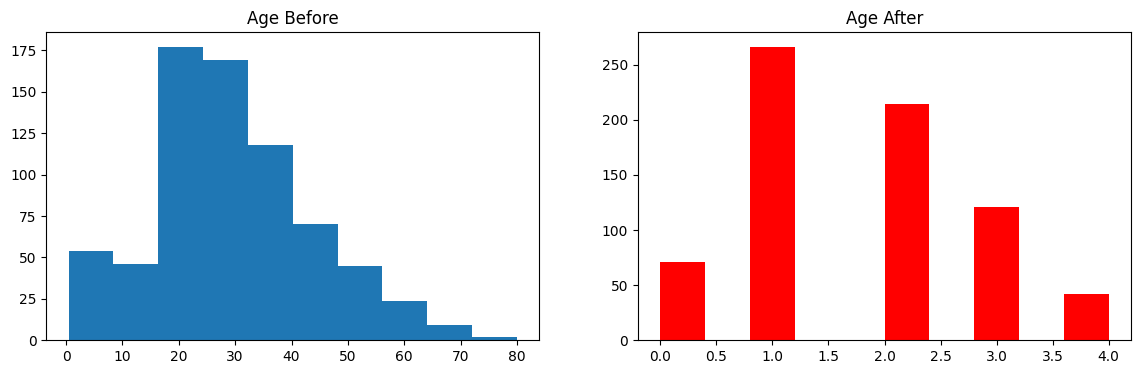

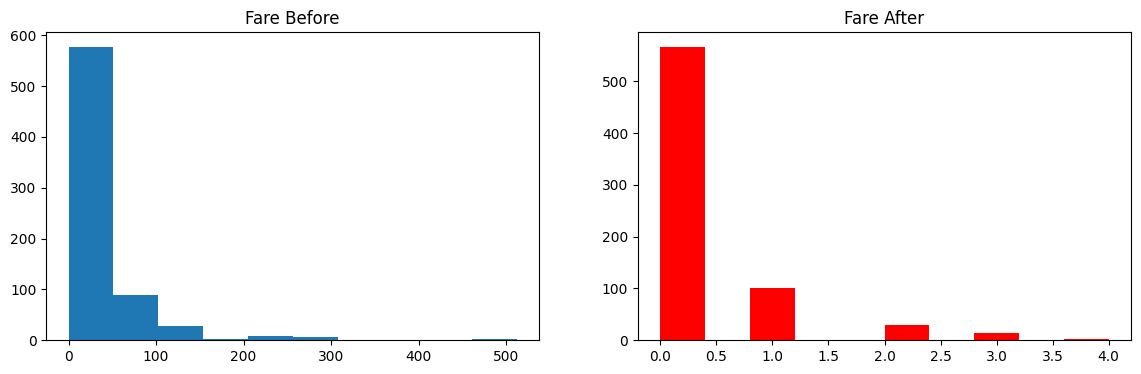

In [23]:
discretize(5,'kmeans')